In [167]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from datetime import datetime
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

In [2]:
fog_train = pd.read_csv('/Users/yunkihun/weather-contest/weather-contest/fog_python/fog_train.csv')
fog_test = pd.read_csv('/Users/yunkihun/weather-contest/weather-contest/fog_python/fog_test.csv')

In [132]:
# 전처리

df = fog_train.drop(columns=[ 
                "Unnamed: 0",
                #"fog_train.year", 
                #"fog_train.month", 
                #"fog_train.day",
                #"fog_train.time",
                #"fog_train.minute",
                #"fog_train.vis1"
                ])

df = df.replace(-99.00, np.NaN)
df = df.replace(-99.90, np.NaN)

fog_train_df = fog_train.replace(-99.00, np.NaN)
fog_train_df = fog_train.replace(-99.90, np.NaN)

columns = df.columns
columns = [column.replace('fog_train.', "") for column in columns]
df.columns = columns

columns = fog_train_df.columns
columns = [column.replace('fog_train.', "") for column in columns]
fog_train_df.columns = columns

df = df.dropna()
fog_train_df = fog_train_df.dropna()

def stn_transform(value):
    if value.startswith("A"):
        return 1
    elif value.startswith("B"):
        return 2
    elif value.startswith("C"):
        return 3
    elif value.startswith("D"):
        return 4
    elif value.startswith("E"):
        return 5
    
df["stn_id"] = df["stn_id"].apply(stn_transform)

df["temp_diff"] = df["ta"] - df["ts"]
df['5hr_chg'] = df['ta'] - df['ta'].shift(5)
df = df.iloc[5:]

df.shape

(2994845, 17)

In [100]:
# CM 함수
def csi_index(cm):

     H = (cm[0][0] + cm[1][1] + cm[2][2])
     F = (cm[0][1] + cm[0][2] + 
          cm[1][0] + cm[1][2] + 
          cm[2][0] + cm[2][1] +
          cm[3][0] + cm[3][1] + cm[3][2])
     M = (cm[0][3] + cm[1][3] + cm[2][3])

     knn_csi = H / (H + F + M)
     return knn_csi

In [101]:
# random forest 함수

def random_forest(df):
    feature_columns = list(df.columns.difference(["class"]))
    X = df[feature_columns]
    y=df["class"]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25, random_state=42)
    
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    
    rf_model.fit(X_train, y_train)
    
    y_pred = rf_model.predict(X_test)
    
    cm = confusion_matrix(y_test, y_pred)
    print(cm)
    print(csi_index(cm))

In [7]:
# 분산 팽창 지수

def calculate_vif(df):
    vif_data = pd.DataFrame()
    vif_data["feature"] = df.columns
    vif_data["VIF"] = [variance_inflation_factor(df.values, i) for i in range(len(df.columns))]
    return vif_data

# EDA

<Axes: xlabel='month', ylabel='vis1'>

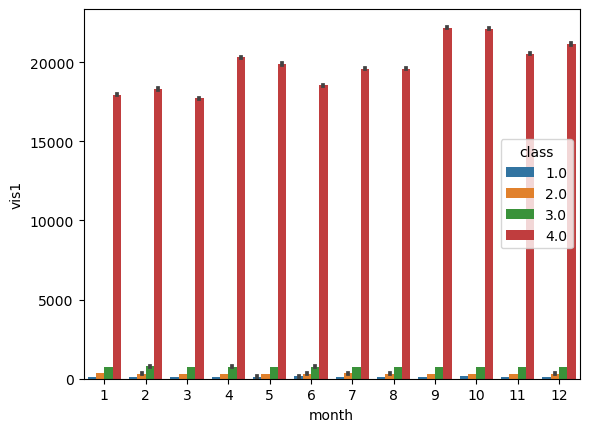

In [4]:
sns.barplot(x='month', y="vis1", hue="class", data=df)

In [4]:
df.loc[df['year'] == "I", "year"] = "2020"
df.loc[df['year'] == "J", "year"] = "2021"
df.loc[df['year'] == "K", "year"] = "2022"
df[['month','day','time','minute']] = df[['month','day','time','minute']].astype(str)

In [21]:
df['period'] = df[['year', 'month','day','time','minute']].agg('-'.join, axis=1)
print(df)

         year month day time minute  stn_id  ws10_deg  ws10_ms   ta   re  \
5        2020     1   1    1      0       1      43.1      1.7 -5.9  0.0   
6        2020     1   1    1     10       1      36.4      1.0 -5.9  0.0   
7        2020     1   1    1     20       1      44.3      0.6 -5.8  0.0   
8        2020     1   1    1     30       1      25.0      0.1 -5.8  0.0   
9        2020     1   1    1     40       1      29.8      0.1 -5.7  0.0   
...       ...   ...  ..  ...    ...     ...       ...      ...  ...  ...   
3156454  2022    12  31   23     10       5     305.3      7.7  2.5  0.0   
3156455  2022    12  31   23     20       5     293.8      5.7  2.3  0.0   
3156456  2022    12  31   23     30       5     274.2      4.9  2.2  0.0   
3156457  2022    12  31   23     40       5     270.3      4.6  2.1  0.0   
3156458  2022    12  31   23     50       5     254.8      4.1  2.1  0.0   

           hm  sun10   ts     vis1  class  temp_diff  5hr_chg  \
5        40.1    0.0 -

In [28]:
df['period'] = pd.to_datetime(df['period'], format="%Y-%m-%d-%H-%M")
df.set_index('period', inplace=True)
df.head(10)

,year,month,day,time,minute,stn_id,ws10_deg,ws10_ms,ta,re,hm,sun10,ts,vis1,class,temp_diff,5hr_chg
period,,,,,,,,,,,,,,,,,
2020-01-01 01:00:00,2020,1,1,1,0,1,43.1,1.7,-5.9,0.0,40.1,0.0,-2.4,20000.0,4.0,-3.5,0.5
2020-01-01 01:10:00,2020,1,1,1,10,1,36.4,1.0,-5.9,0.0,40.0,0.0,-2.5,20000.0,4.0,-3.4,0.4
2020-01-01 01:20:00,2020,1,1,1,20,1,44.3,0.6,-5.8,0.0,40.7,0.0,-2.5,20000.0,4.0,-3.3,0.5
2020-01-01 01:30:00,2020,1,1,1,30,1,25.0,0.1,-5.8,0.0,41.7,0.0,-2.5,20000.0,4.0,-3.3,0.4
2020-01-01 01:40:00,2020,1,1,1,40,1,29.8,0.1,-5.7,0.0,41.4,0.0,-2.5,18510.0,4.0,-3.2,0.4
2020-01-01 01:50:00,2020,1,1,1,50,1,0.0,0.1,-5.7,0.0,41.3,0.0,-2.5,20000.0,4.0,-3.2,0.2
2020-01-01 02:00:00,2020,1,1,2,0,1,0.0,0.1,-5.7,0.0,42.4,0.0,-2.4,20000.0,4.0,-3.3,0.2
2020-01-01 02:10:00,2020,1,1,2,10,1,0.0,0.0,-5.6,0.0,42.2,0.0,-2.4,20000.0,4.0,-3.2,0.2
2020-01-01 02:20:00,2020,1,1,2,20,1,38.5,0.1,-5.5,0.0,43.6,0.0,-2.6,18971.0,4.0,-2.9,0.3


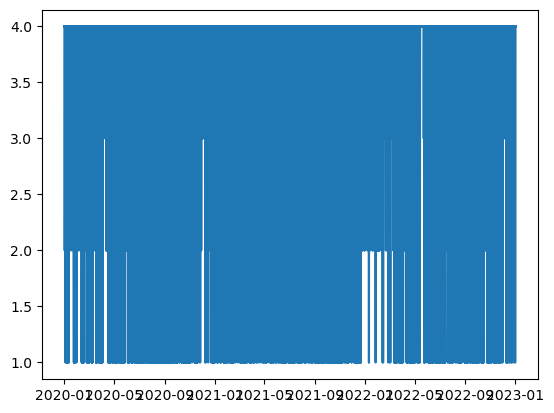

<Figure size 30000x4000 with 0 Axes>

In [34]:
plt.plot(df.index, df['class'])
plt.figure(figsize=(300,40))
plt.show()

In [39]:
df.reset_index(inplace=True)

In [7]:
# class4를 빼고 돌려보자
df_fog = df[df['class'] != 4]

<Axes: xlabel='month', ylabel='class'>

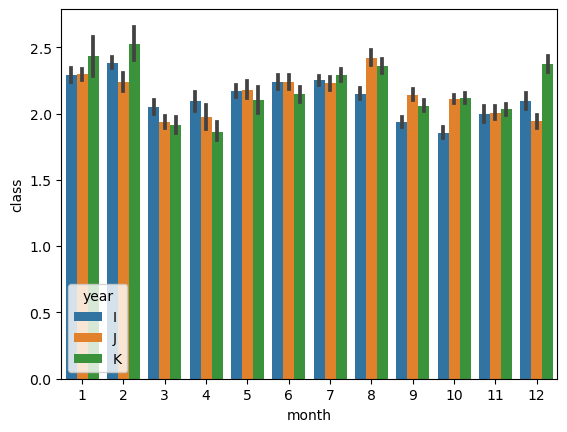

In [8]:
sns.barplot(x='month', y='class',hue='year', data=df_fog)

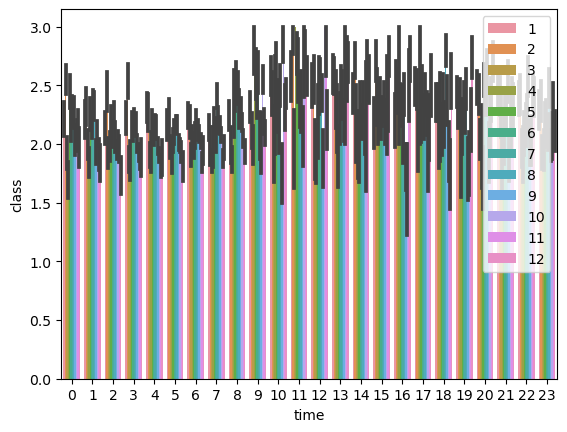

In [10]:
sns.barplot(x='time', y='class',hue='month', data=df_fog)
plt.legend(loc="upper right")

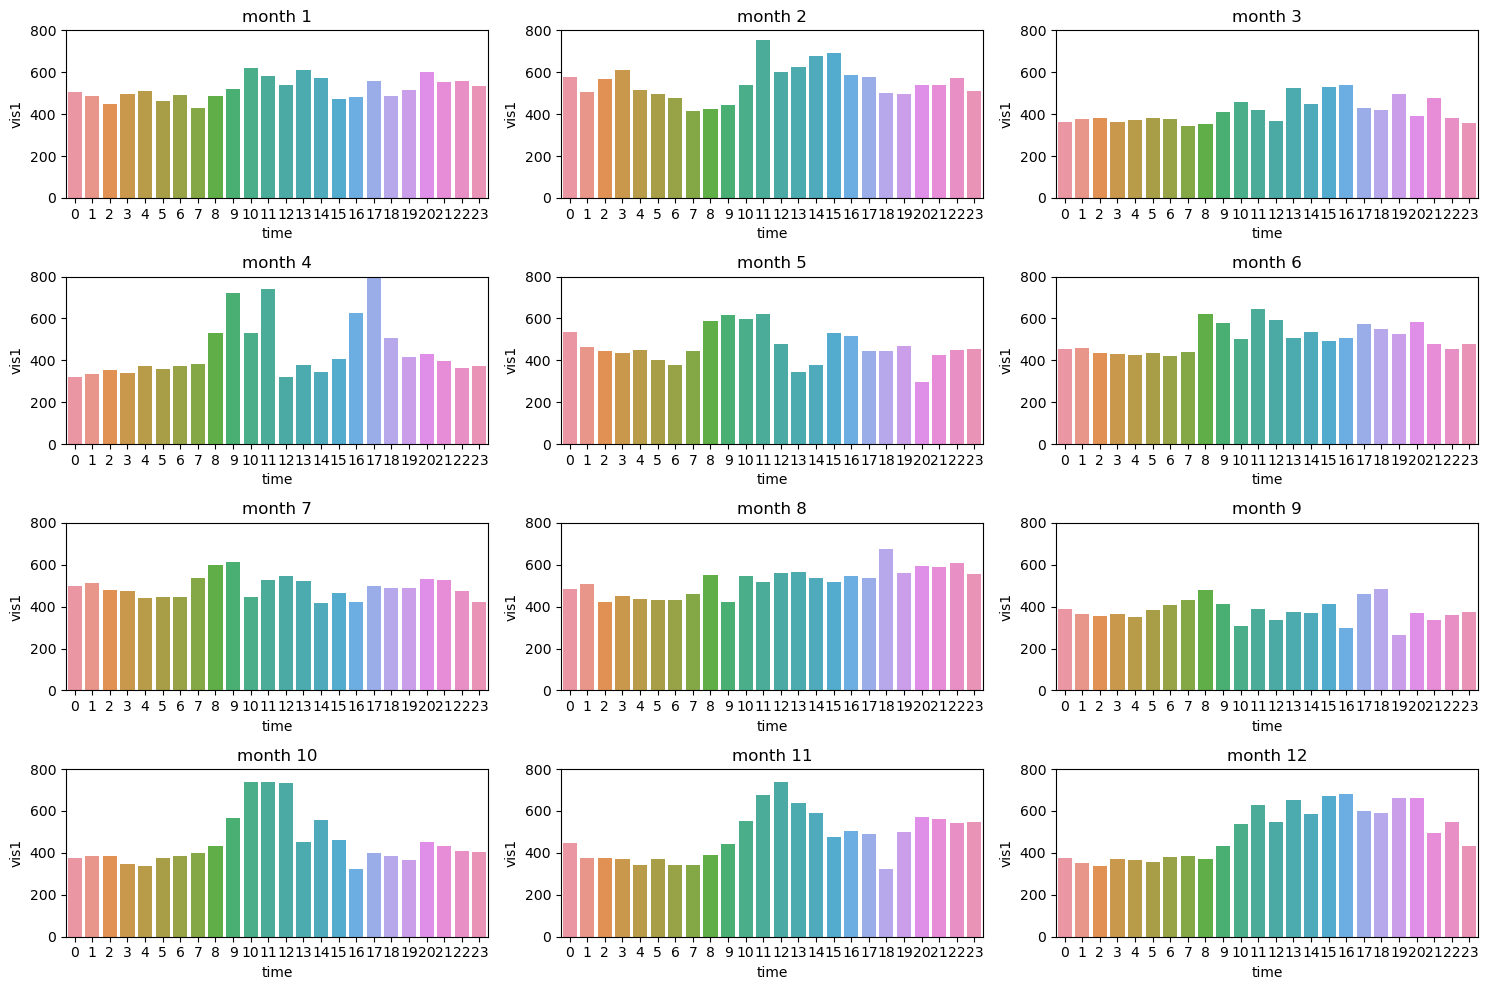

In [84]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 10))
        
for i in range(12):
    row = i // 3
    col = i % 3
    sns.barplot(x='time', y='vis1', data=df_fog[df_fog['month'] == (i+1)], errorbar=None, ax=axes[row, col]).set(ylim=(0,800))
    axes[row][col].set_title(f'month {i+1}')
            
plt.tight_layout()
plt.show()

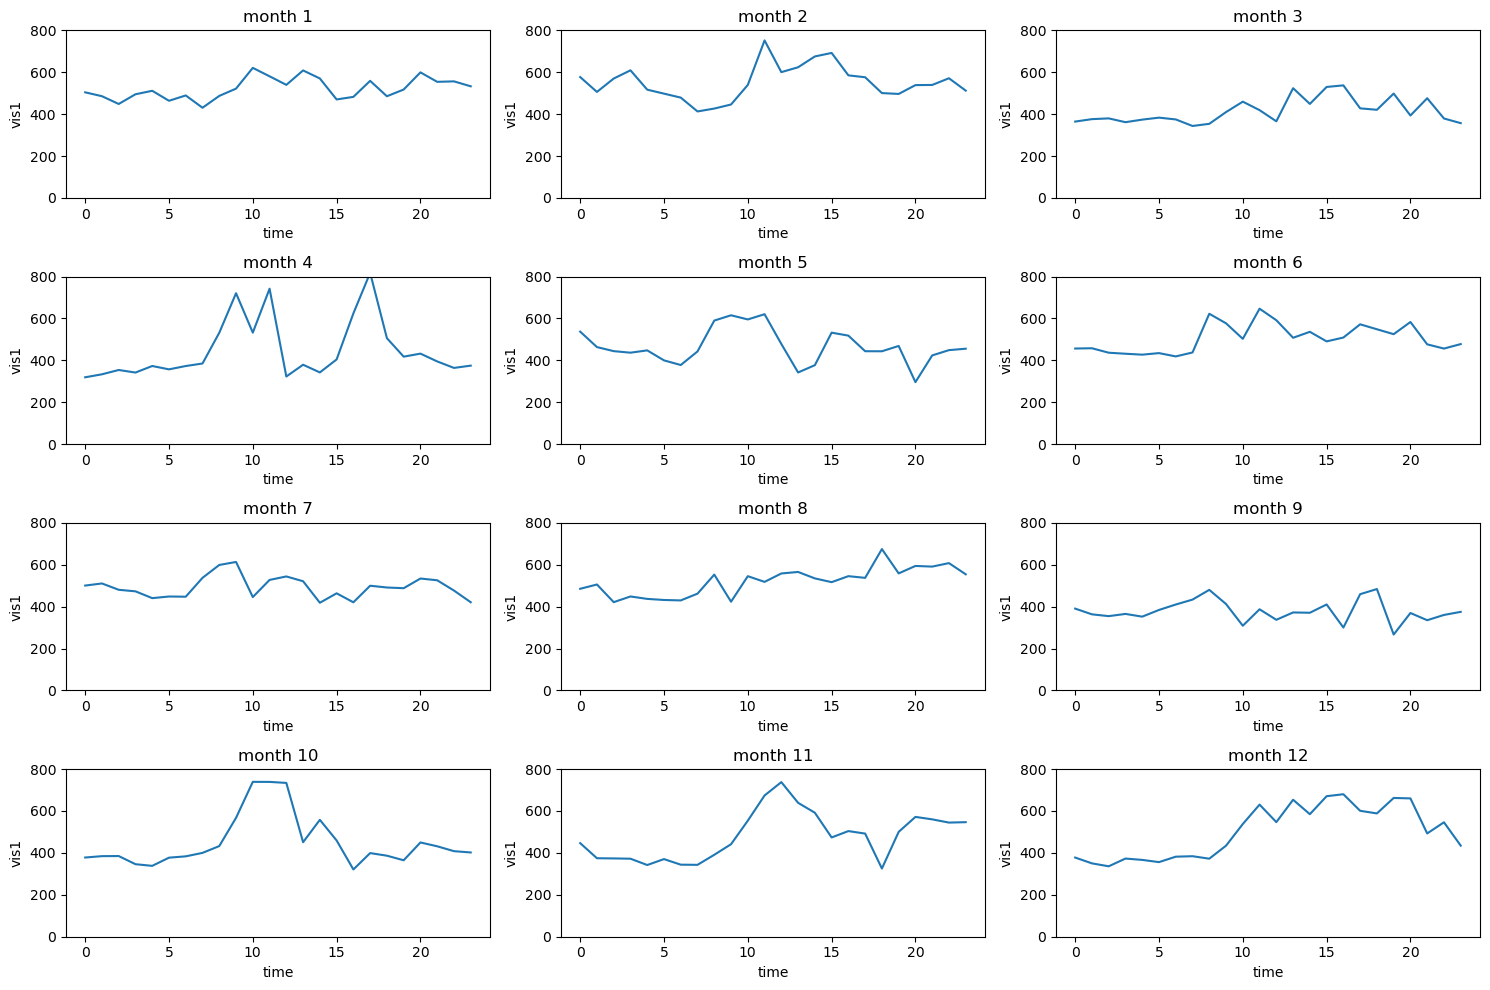

In [85]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 10))
        
for i in range(12):
    row = i // 3
    col = i % 3
    sns.lineplot(x='time', y='vis1', data=df_fog[df_fog['month'] == (i+1)], errorbar=None, ax=axes[row, col]).set(ylim=(0,800))
    axes[row][col].set_title(f'month {i+1}')
            
plt.tight_layout()
plt.show()

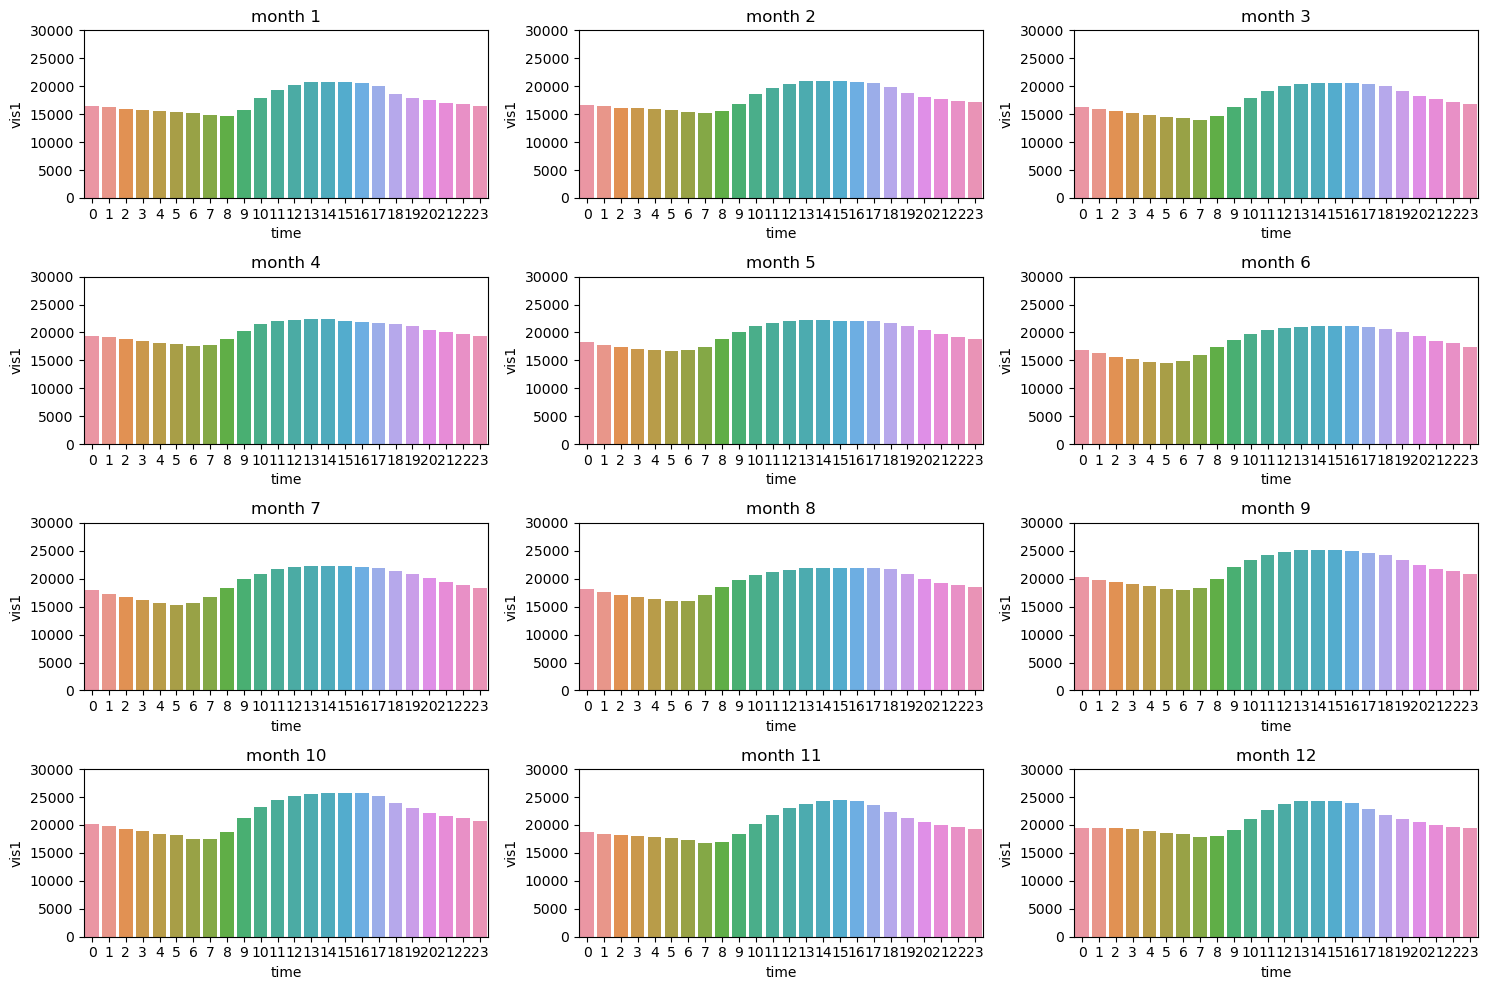

In [91]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 10))
        
for i in range(12):
    row = i // 3
    col = i % 3
    sns.barplot(x='time', y='vis1', data=df[df['month'] == (i+1)], errorbar=None, ax=axes[row, col]).set(ylim=(0,30000))
    axes[row][col].set_title(f'month {i+1}')
            
plt.tight_layout()
plt.show()

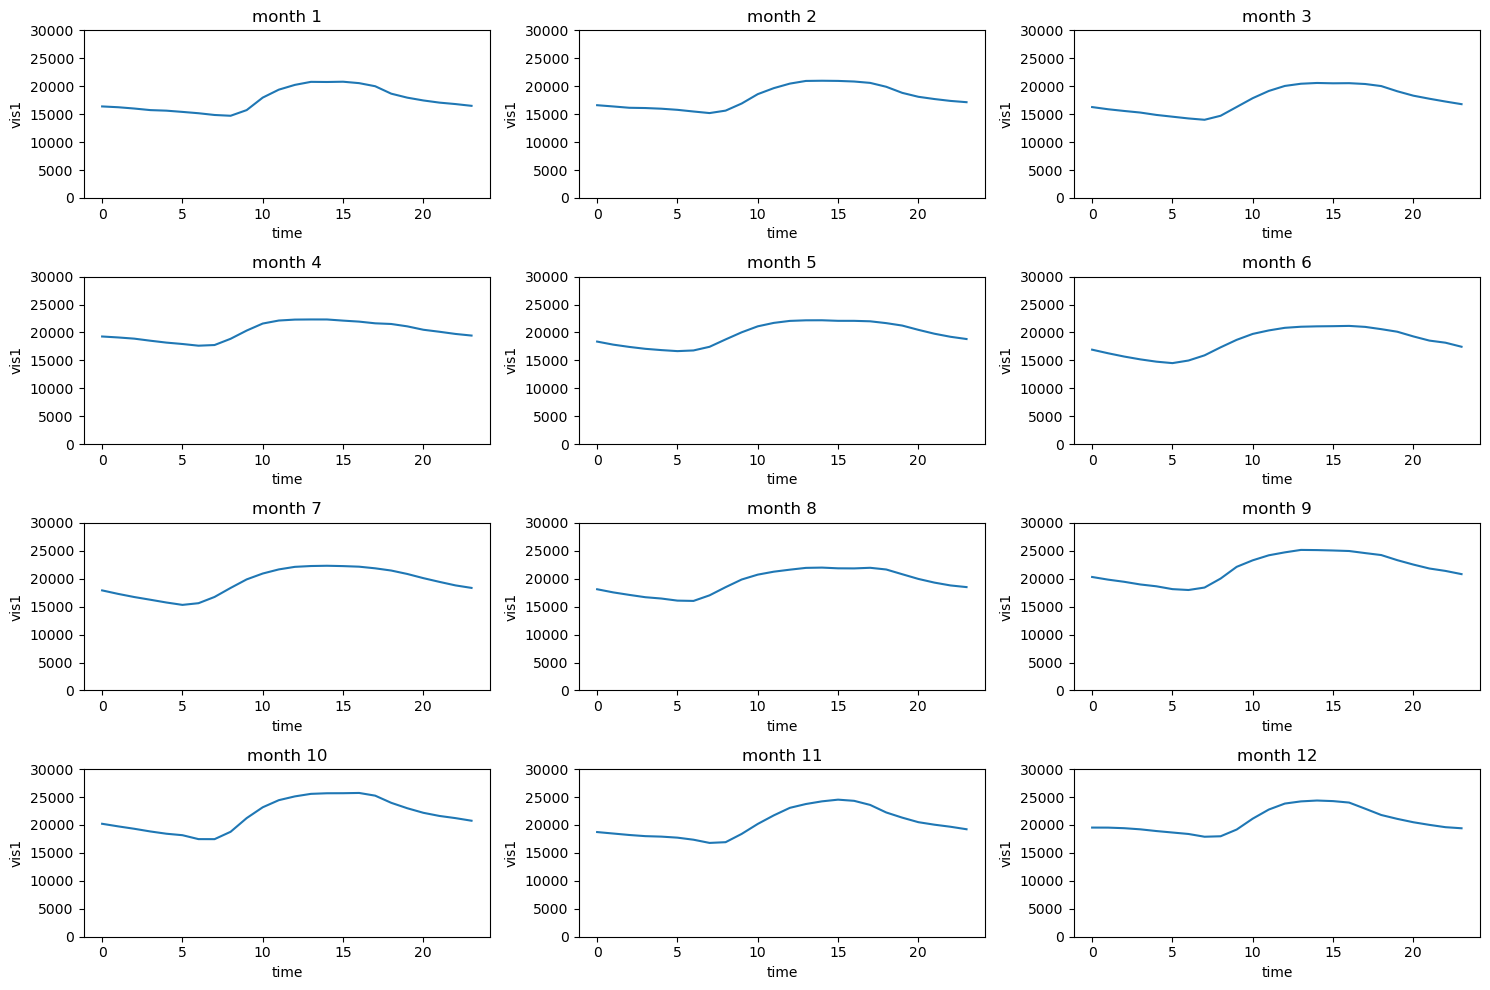

In [92]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 10))
        
for i in range(12):
    row = i // 3
    col = i % 3
    sns.lineplot(x='time', y='vis1', data=df[df['month'] == (i+1)], errorbar=None, ax=axes[row, col]).set(ylim=(0,30000))
    axes[row][col].set_title(f'month {i+1}')
            
plt.tight_layout()
plt.show()

[(0.0, 30000.0)]

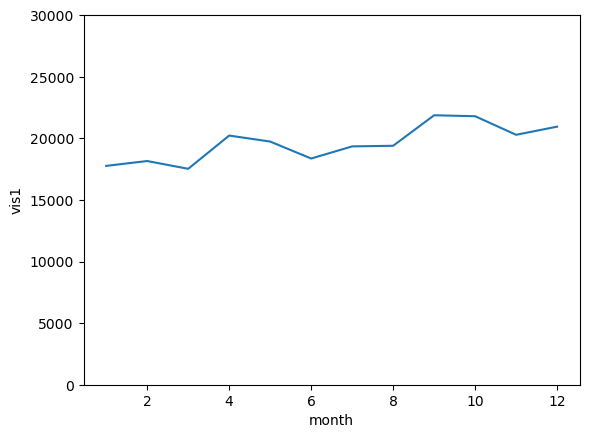

In [94]:
sns.lineplot(x='month', y='vis1', data=df, errorbar=None).set(ylim=(0,30000))

[(0.0, 30000.0)]

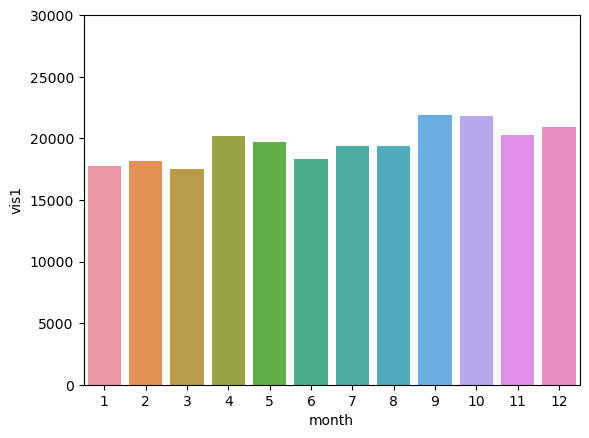

In [95]:
sns.barplot(x='month', y='vis1', data=df, errorbar=None).set(ylim=(0,30000))

In [136]:
# 권역별로 나눠보자
df_stn1 = df[df["stn_id"] == 1]
df_stn2 = df[df["stn_id"] == 2]
df_stn3 = df[df["stn_id"] == 3]
df_stn4 = df[df["stn_id"] == 4]
df_stn5 = df[df["stn_id"] == 5]

In [144]:
fig,axes = plt.subplots(nrows=3,ncols=2, figsize=(100,100))

sns.barplot(x='month', y='vis1', data=df_stn1, errorbar=None, ax=axes[0,0]).set(ylim=(0,30000))
sns.barplot(x='month', y='vis1', data=df_stn2, errorbar=None, ax=axes[0,1]).set(ylim=(0,30000))
sns.barplot(x='month', y='vis1', data=df_stn3, errorbar=None, ax=axes[1,0]).set(ylim=(0,30000))
sns.barplot(x='month', y='vis1', data=df_stn4, errorbar=None, ax=axes[1,1]).set(ylim=(0,30000))
sns.barplot(x='month', y='vis1', data=df_stn5, errorbar=None, ax=axes[2,0]).set(ylim=(0,30000))

[(0.0, 30000.0)]

In [145]:
fig,axes = plt.subplots(nrows=3,ncols=2, figsize=(100,100))

sns.lineplot(x='month', y='vis1', data=df_stn1, errorbar=None, ax=axes[0,0]).set(ylim=(0,30000))
sns.lineplot(x='month', y='vis1', data=df_stn2, errorbar=None, ax=axes[0,1]).set(ylim=(0,30000))
sns.lineplot(x='month', y='vis1', data=df_stn3, errorbar=None, ax=axes[1,0]).set(ylim=(0,30000))
sns.lineplot(x='month', y='vis1', data=df_stn4, errorbar=None, ax=axes[1,1]).set(ylim=(0,30000))
sns.lineplot(x='month', y='vis1', data=df_stn5, errorbar=None, ax=axes[2,0]).set(ylim=(0,30000))

[(0.0, 30000.0)]

# 시간/지표 기온차 변수 추가

In [5]:
df.corr()

,stn_id,ws10_deg,ws10_ms,ta,re,hm,sun10,ts,class
stn_id,1.000000,-0.061468,0.254918,0.027946,-0.023674,0.023762,0.004652,0.028720,-0.008530
ws10_deg,-0.061468,1.000000,0.200242,-0.068713,-0.047907,-0.225108,0.086370,-0.044935,0.022142
ws10_ms,0.254918,0.200242,1.000000,0.011221,0.007804,-0.292699,0.218815,0.073004,0.047796
ta,0.027946,-0.068713,0.011221,1.000000,0.048411,0.142129,0.272359,0.915636,0.031992
re,-0.023674,-0.047907,0.007804,0.048411,1.000000,0.263228,-0.124162,0.016516,-0.041112
hm,0.023762,-0.225108,-0.292699,0.142129,0.263228,1.000000,-0.430115,0.007288,-0.120866
sun10,0.004652,0.086370,0.218815,0.272359,-0.124162,-0.430115,1.000000,0.550451,0.051728
ts,0.028720,-0.044935,0.073004,0.915636,0.016516,0.007288,0.550451,1.000000,0.030398
class,-0.008530,0.022142,0.047796,0.031992,-0.041112,-0.120866,0.051728,0.030398,1.000000


In [8]:
calculate_vif(df)

,feature,VIF
0,stn_id,3.993145
1,ws10_deg,4.320963
2,ws10_ms,3.180609
3,ta,36.428766
4,re,1.150779
5,hm,15.931263
6,sun10,4.783270
7,ts,44.426062
8,class,25.366874


In [97]:
# https://www.notion.so/734ee170e8d94533a1707405cfe9f8d2
# 기온/지면온도 온도차, 5시간 기온 변화량을 적용해볼 필요가 있어 보인다.
# 기온/지면 온도차
df["temp_diff"] = df["ta"] - df["ts"]

In [98]:
# 5시간 기온 차 (현재시간 기온 - 5시간 전 시간 기온)
df['5hr_chg'] = df['ta'] - df['ta'].shift(5)

In [99]:
# 맨 앞의 5개 데이터는 어쩔 수 없이 지우자
df = df.iloc[5:]

In [100]:
df

,month,stn_id,ws10_deg,ws10_ms,ta,re,hm,sun10,ts,class,temp_diff,5hr_chg
5,1,1,43.1,1.7,-5.9,0.0,40.1,0.0,-2.4,4.0,-3.5,0.5
6,1,1,36.4,1.0,-5.9,0.0,40.0,0.0,-2.5,4.0,-3.4,0.4
7,1,1,44.3,0.6,-5.8,0.0,40.7,0.0,-2.5,4.0,-3.3,0.5
8,1,1,25.0,0.1,-5.8,0.0,41.7,0.0,-2.5,4.0,-3.3,0.4
9,1,1,29.8,0.1,-5.7,0.0,41.4,0.0,-2.5,4.0,-3.2,0.4
...,...,...,...,...,...,...,...,...,...,...,...,...
3156454,12,5,305.3,7.7,2.5,0.0,50.2,0.0,-0.9,4.0,3.4,0.2
3156455,12,5,293.8,5.7,2.3,0.0,50.1,0.0,-1.3,4.0,3.6,0.0
3156456,12,5,274.2,4.9,2.2,0.0,51.0,0.0,-1.4,4.0,3.6,-0.1
3156457,12,5,270.3,4.6,2.1,0.0,51.7,0.0,-1.6,4.0,3.7,-0.2


In [38]:
df.corr()

,stn_id,ws10_deg,ws10_ms,ta,re,hm,sun10,ts,class,temp_diff,5hr_chg
stn_id,1.000000,-0.061471,0.254917,0.027943,-0.023675,0.023760,0.004651,0.028718,-0.008530,-0.014924,0.000055
ws10_deg,-0.061471,1.000000,0.200240,-0.068719,-0.047907,-0.225112,0.086369,-0.044940,0.022142,-0.024904,-0.004358
ws10_ms,0.254917,0.200240,1.000000,0.011217,0.007803,-0.292702,0.218814,0.073001,0.047797,-0.153430,-0.009955
ta,0.027943,-0.068719,0.011217,1.000000,0.048410,0.142125,0.272358,0.915636,0.031992,-0.265205,0.047866
re,-0.023675,-0.047907,0.007803,0.048410,1.000000,0.263228,-0.124163,0.016515,-0.041112,0.053864,-0.067984
hm,0.023760,-0.225112,-0.292702,0.142125,0.263228,1.000000,-0.430117,0.007285,-0.120866,0.256956,-0.086446
sun10,0.004651,0.086369,0.218814,0.272358,-0.124163,-0.430117,1.000000,0.550451,0.051728,-0.794329,0.521658
ts,0.028718,-0.044940,0.073001,0.915636,0.016515,0.007285,0.550451,1.000000,0.030398,-0.630444,0.192618
class,-0.008530,0.022142,0.047797,0.031992,-0.041112,-0.120866,0.051728,0.030398,1.000000,-0.011135,0.014150
temp_diff,-0.014924,-0.024904,-0.153430,-0.265205,0.053864,0.256956,-0.794329,-0.630444,-0.011135,1.000000,-0.369558


In [39]:
calculate_vif(df)

/Users/yunkihun/anaconda3/lib/python3.11/site-packages/statsmodels/stats/outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,feature,VIF
0,stn_id,3.995046
1,ws10_deg,4.322989
2,ws10_ms,3.220996
3,ta,inf
4,re,1.151679
5,hm,16.579749
6,sun10,6.134028
7,ts,inf
8,class,26.151893
9,temp_diff,inf


In [40]:
random_forest(df)

[[   657    208     10   1076]
 [   159    822    116   1897]
 [    13    178    336   2458]
 [    31    121    127 740503]]
0.22109879400657814


# 계절 / 월 추가

In [94]:
# 안개도 계절에 영향을 많이 받는 것 같으니, 계절 변수를 추가해보자

def season(df):
    conditions = [
        (df['month'] == 12) | (df['month'] == 1) | (df['month'] == 2),
        (df['month'] == 3) | (df['month'] == 4) | (df['month'] == 5),
        (df['month'] == 6) | (df['month'] == 7) | (df['month'] == 8),
        (df['month'] == 9) | (df['month'] == 10) | (df['month'] == 11)
    ]

    choices = [1, 2, 3, 4]

    df['season'] = np.select(conditions, choices, default='Unknown')

In [101]:
season(df)

In [102]:
df = df.drop(columns=["month"])

In [103]:
random_forest(df)

[[   723    237      9    982]
 [   175    889    124   1806]
 [    18    183    350   2434]
 [    35    125    131 740491]]
0.23865709767668167


In [105]:
# 이번엔 계절을 추가하지 않고, raw month data로 돌려보자
df

,month,stn_id,ws10_deg,ws10_ms,ta,re,hm,sun10,ts,class,temp_diff,5hr_chg
5,1,1,43.1,1.7,-5.9,0.0,40.1,0.0,-2.4,4.0,-3.5,0.5
6,1,1,36.4,1.0,-5.9,0.0,40.0,0.0,-2.5,4.0,-3.4,0.4
7,1,1,44.3,0.6,-5.8,0.0,40.7,0.0,-2.5,4.0,-3.3,0.5
8,1,1,25.0,0.1,-5.8,0.0,41.7,0.0,-2.5,4.0,-3.3,0.4
9,1,1,29.8,0.1,-5.7,0.0,41.4,0.0,-2.5,4.0,-3.2,0.4
...,...,...,...,...,...,...,...,...,...,...,...,...
3156454,12,5,305.3,7.7,2.5,0.0,50.2,0.0,-0.9,4.0,3.4,0.2
3156455,12,5,293.8,5.7,2.3,0.0,50.1,0.0,-1.3,4.0,3.6,0.0
3156456,12,5,274.2,4.9,2.2,0.0,51.0,0.0,-1.4,4.0,3.6,-0.1
3156457,12,5,270.3,4.6,2.1,0.0,51.7,0.0,-1.6,4.0,3.7,-0.2


In [106]:
random_forest(df)

[[   791    240     14    906]
 [   183    958    138   1715]
 [    17    207    380   2381]
 [    35    119    144 740484]]
0.258750607681089


In [110]:
# 이번엔 time 도 되살려서 해보자
df

,month,time,stn_id,ws10_deg,ws10_ms,ta,re,hm,sun10,ts,class,temp_diff,5hr_chg
5,1,1,1,43.1,1.7,-5.9,0.0,40.1,0.0,-2.4,4.0,-3.5,0.5
6,1,1,1,36.4,1.0,-5.9,0.0,40.0,0.0,-2.5,4.0,-3.4,0.4
7,1,1,1,44.3,0.6,-5.8,0.0,40.7,0.0,-2.5,4.0,-3.3,0.5
8,1,1,1,25.0,0.1,-5.8,0.0,41.7,0.0,-2.5,4.0,-3.3,0.4
9,1,1,1,29.8,0.1,-5.7,0.0,41.4,0.0,-2.5,4.0,-3.2,0.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3156454,12,23,5,305.3,7.7,2.5,0.0,50.2,0.0,-0.9,4.0,3.4,0.2
3156455,12,23,5,293.8,5.7,2.3,0.0,50.1,0.0,-1.3,4.0,3.6,0.0
3156456,12,23,5,274.2,4.9,2.2,0.0,51.0,0.0,-1.4,4.0,3.6,-0.1
3156457,12,23,5,270.3,4.6,2.1,0.0,51.7,0.0,-1.6,4.0,3.7,-0.2


In [109]:
random_forest(df)

[[   832    260     15    844]
 [   189   1036    131   1638]
 [    15    220    405   2345]
 [    18    100    158 740506]]
0.2769924445527663


# 이슬점

In [96]:
def calculate_dew_point(T, RH):
    a = 17.27
    b = 237.7
    gamma = (a * T) / (b + T) + np.log(RH / 100.0)
    dew_point = (b * gamma) / (a - gamma)
    return dew_point

In [146]:
df['dew_point'] = calculate_dew_point(df['ta'], df['hm'])

/Users/yunkihun/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [147]:
dew_re_list = []
for i in range(len(df)):
    if df['ts'].values[i] < df['dew_point'].values[i]:
        dew_re_list.append(1)
    else:
        dew_re_list.append(0)
df['dew_reached'] = dew_re_list
df

,year,month,day,time,minute,stn_id,ws10_deg,ws10_ms,ta,re,hm,sun10,ts,vis1,class,temp_diff,5hr_chg,dew_point,dew_reached
5,I,1,1,1,0,1,43.1,1.7,-5.9,0.0,40.1,0.0,-2.4,20000.0,4.0,-3.5,0.5,-17.273744,0
6,I,1,1,1,10,1,36.4,1.0,-5.9,0.0,40.0,0.0,-2.5,20000.0,4.0,-3.4,0.4,-17.303294,0
7,I,1,1,1,20,1,44.3,0.6,-5.8,0.0,40.7,0.0,-2.5,20000.0,4.0,-3.3,0.5,-17.007249,0
8,I,1,1,1,30,1,25.0,0.1,-5.8,0.0,41.7,0.0,-2.5,20000.0,4.0,-3.3,0.4,-16.718882,0
9,I,1,1,1,40,1,29.8,0.1,-5.7,0.0,41.4,0.0,-2.5,18510.0,4.0,-3.2,0.4,-16.714006,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3156454,K,12,31,23,10,5,305.3,7.7,2.5,0.0,50.2,0.0,-0.9,20000.0,4.0,3.4,0.2,-6.810493,0
3156455,K,12,31,23,20,5,293.8,5.7,2.3,0.0,50.1,0.0,-1.3,20000.0,4.0,3.6,0.0,-7.021146,0
3156456,K,12,31,23,30,5,274.2,4.9,2.2,0.0,51.0,0.0,-1.4,20000.0,4.0,3.6,-0.1,-6.882689,0
3156457,K,12,31,23,40,5,270.3,4.6,2.1,0.0,51.7,0.0,-1.6,20000.0,4.0,3.7,-0.2,-6.798347,0


In [148]:
df = df.drop(columns=['year','day','minute','vis1', 'dew_point'])

In [149]:
df

,month,time,stn_id,ws10_deg,ws10_ms,ta,re,hm,sun10,ts,class,temp_diff,5hr_chg,dew_reached
5,1,1,1,43.1,1.7,-5.9,0.0,40.1,0.0,-2.4,4.0,-3.5,0.5,0
6,1,1,1,36.4,1.0,-5.9,0.0,40.0,0.0,-2.5,4.0,-3.4,0.4,0
7,1,1,1,44.3,0.6,-5.8,0.0,40.7,0.0,-2.5,4.0,-3.3,0.5,0
8,1,1,1,25.0,0.1,-5.8,0.0,41.7,0.0,-2.5,4.0,-3.3,0.4,0
9,1,1,1,29.8,0.1,-5.7,0.0,41.4,0.0,-2.5,4.0,-3.2,0.4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3156454,12,23,5,305.3,7.7,2.5,0.0,50.2,0.0,-0.9,4.0,3.4,0.2,0
3156455,12,23,5,293.8,5.7,2.3,0.0,50.1,0.0,-1.3,4.0,3.6,0.0,0
3156456,12,23,5,274.2,4.9,2.2,0.0,51.0,0.0,-1.4,4.0,3.6,-0.1,0
3156457,12,23,5,270.3,4.6,2.1,0.0,51.7,0.0,-1.6,4.0,3.7,-0.2,0


In [109]:
df.isna().sum()

month          0
time           0
stn_id         0
ws10_deg       0
ws10_ms        0
ta             0
re             0
hm             0
sun10          0
ts             0
class          0
temp_diff      0
5hr_chg        0
dew_point      1
dew_reached    0
dtype: int64

In [110]:
na_rows = df[df.isna().any(axis=1)]
print(na_rows)

         month  time  stn_id  ws10_deg  ws10_ms   ta   re   hm  sun10   ts  \
1001345     12    22       5     278.1      0.5 -0.9  0.0  0.0    0.0 -1.3   

         class  temp_diff  5hr_chg  dew_point  dew_reached  
1001345    4.0        0.4     -1.0        NaN            0  


In [118]:
np.log(0 / 100.0)

/var/folders/ld/bjk749657q3gc2fpmc3lht4m0000gn/T/ipykernel_26692/2295081803.py:1: RuntimeWarning: divide by zero encountered in log
  np.log(0 / 100.0)


-inf

In [117]:
df[df['hm'] == 0]

,month,time,stn_id,ws10_deg,ws10_ms,ta,re,hm,sun10,ts,class,temp_diff,5hr_chg,dew_point,dew_reached
1001345,12,22,5,278.1,0.5,-0.9,0.0,0.0,0.0,-1.3,4.0,0.4,-1.0,NaN,0


In [120]:
# 고민 끝에 drop하기로 결정
df.drop(index=1001345, inplace=True)

In [121]:
df

,month,time,stn_id,ws10_deg,ws10_ms,ta,re,hm,sun10,ts,class,temp_diff,5hr_chg,dew_point,dew_reached
5,1,1,1,43.1,1.7,-5.9,0.0,40.1,0.0,-2.4,4.0,-3.5,0.5,-17.273744,0
6,1,1,1,36.4,1.0,-5.9,0.0,40.0,0.0,-2.5,4.0,-3.4,0.4,-17.303294,0
7,1,1,1,44.3,0.6,-5.8,0.0,40.7,0.0,-2.5,4.0,-3.3,0.5,-17.007249,0
8,1,1,1,25.0,0.1,-5.8,0.0,41.7,0.0,-2.5,4.0,-3.3,0.4,-16.718882,0
9,1,1,1,29.8,0.1,-5.7,0.0,41.4,0.0,-2.5,4.0,-3.2,0.4,-16.714006,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3156454,12,23,5,305.3,7.7,2.5,0.0,50.2,0.0,-0.9,4.0,3.4,0.2,-6.810493,0
3156455,12,23,5,293.8,5.7,2.3,0.0,50.1,0.0,-1.3,4.0,3.6,0.0,-7.021146,0
3156456,12,23,5,274.2,4.9,2.2,0.0,51.0,0.0,-1.4,4.0,3.6,-0.1,-6.882689,0
3156457,12,23,5,270.3,4.6,2.1,0.0,51.7,0.0,-1.6,4.0,3.7,-0.2,-6.798347,0


In [122]:
random_forest(df)

[[   842    254     14    841]
 [   197   1032    139   1626]
 [    16    224    404   2341]
 [    24     96    170 740491]]
0.27712895377128954


In [123]:
df = df.drop(columns=['dew_point'])

In [125]:
# 이번에는 이슬점 빼고, 이슬점 도달 여부만 넣어 확인
random_forest(df)

[[   841    252     12    846]
 [   192   1034    146   1622]
 [    16    217    405   2347]
 [    21     97    172 740491]]
0.2773722627737226


# 과대표집

In [158]:
# 마지막 모델 (이슬점 도달까지 포함)으로 과대표집 진행
df

,month,time,stn_id,ws10_deg,ws10_ms,ta,re,hm,sun10,ts,class,temp_diff,5hr_chg,dew_reached
5,1,1,1,43.1,1.7,-5.9,0.0,40.1,0.0,-2.4,4.0,-3.5,0.5,0
6,1,1,1,36.4,1.0,-5.9,0.0,40.0,0.0,-2.5,4.0,-3.4,0.4,0
7,1,1,1,44.3,0.6,-5.8,0.0,40.7,0.0,-2.5,4.0,-3.3,0.5,0
8,1,1,1,25.0,0.1,-5.8,0.0,41.7,0.0,-2.5,4.0,-3.3,0.4,0
9,1,1,1,29.8,0.1,-5.7,0.0,41.4,0.0,-2.5,4.0,-3.2,0.4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3156454,12,23,5,305.3,7.7,2.5,0.0,50.2,0.0,-0.9,4.0,3.4,0.2,0
3156455,12,23,5,293.8,5.7,2.3,0.0,50.1,0.0,-1.3,4.0,3.6,0.0,0
3156456,12,23,5,274.2,4.9,2.2,0.0,51.0,0.0,-1.4,4.0,3.6,-0.1,0
3156457,12,23,5,270.3,4.6,2.1,0.0,51.7,0.0,-1.6,4.0,3.7,-0.2,0


In [159]:
feature_columns = list(df.columns.difference(["class"]))
X = df[feature_columns]
y=df["class"]

In [160]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25, random_state=42)

In [161]:
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_train,y_train)
print('Resampled dataset shape :', Counter(y_res))

Resampled dataset shape : Counter({4.0: 2222342, 2.0: 2222342, 3.0: 2222342, 1.0: 2222342})


In [162]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

rf_model.fit(X_res, y_res)

RandomForestClassifier(random_state=42)

In [163]:
y_pred = rf_model.predict(X_test)

In [164]:
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.99


In [165]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         1.0       0.59      0.57      0.58      1951
         2.0       0.42      0.51      0.46      2994
         3.0       0.33      0.32      0.32      2985
         4.0       1.00      1.00      1.00    740782

    accuracy                           0.99    748712
   macro avg       0.58      0.60      0.59    748712
weighted avg       0.99      0.99      0.99    748712



In [166]:
cm = confusion_matrix(y_test, y_pred)
print(cm)

csi_index(cm)

[[  1120    420     50    361]
 [   288   1525    417    764]
 [    58    476    941   1510]
 [   430   1173   1463 737716]]


0.3261185885776646

# 하이퍼 파라미터 튜닝

In [168]:
custom_scorer = make_scorer(csi_index)

In [169]:
params = {
    'n_estimators':[100,200,300],
    'max_depth' : [3,5,7], 
    'min_samples_leaf' : [4, 6, 9],
    'min_samples_split' : [4, 8, 10]
}

In [ ]:
grid_search = GridSearchCV(estimator=rf_model, param_grid=params, scoring=custom_scorer, cv=3, verbose=1, n_jobs=-1)
grid_search.fit(X_res, y_res)

print(f"Best parameters found: {grid_search.best_params_}")
print(f"Best cross-validation accuracy: {grid_search.best_score_}")

In [ ]:
best_model = grid_search.best_estimator_

In [ ]:
# pickle

with open(f'''random_forest_{datetime.now().strftime('%Y%m%d%H%M%S')}.pkl''', 'wb') as file:
  pickle.dump(best_model, file)